# NBA Draft Scraper - Basketball Reference + Data Analysis

### Project Overview:

#### Objective:

I wish to collect the career stats of top picks from the past 20 NBA drafts. I will compare numerical stats among players in drafts using graphs and visualization techniques and will also explore interesting relationships among the scraped data with different visualization techniques.
#### Tasks:

1. From www.basketball-reference.com/draft, scrape the rookie stats of the top 10 overall picks of last 20 NBA drafts (2001 - 2020)
2. Scrape data into a single Pandas MultiIndexDataFrame with outer index of draft year and inner index of pick number
3. Run EDA and visualizations to compare top 10 picks in drafts and visualize relationships between the scraped data.

### Imports

In [79]:
import pandas as pd
import numpy as np
from scipy import stats

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Scraper Code

In [80]:
player_data = {'team_id':[],'pos':[],'player':[],'mp_per_g':[],'efg_pct':[],
               'pts_per_g':[],'trb_per_g':[],'ast_per_g':[],'ws':[],'bpm':[]}

index_array = [[],[]]

positions = ['Point Guard','Shooting Guard','Small Forward','Power Forward','Center']

In [81]:
def get_doc(url):   # return BeautifulSoup parsed document
    response = requests.get(url)
    response.close()
    soup = BeautifulSoup(response.text,'html.parser')
    return soup


def scrape_draft(doc,year): #Scrape players' data for single draft
    tr_tags = doc.findAll('tr')
    for pick in range(2,12,1):
        get_advanced_stats(tr_tags, pick)
        player_url = "https://www.basketball-reference.com" + tr_tags[pick].find('td',{'data-stat':'player'}).a['href']
        get_player_data(get_doc(player_url))
        index_array[0].append(year)
        index_array[1].append(pick - 1)
        
        
def get_advanced_stats(tags, pick):  #Scrape player's career advanced stats from the draft page
    for key in ['ws','bpm','player']:
        field = tags[pick].find('td',{'data-stat': key})
        if field is not None:
            player_data[key].append(field.text)
        else:
            player_data[key].append(np.NaN)

    
def get_player_data(doc):  # Scraper player's rookie season data off of individual page
    rookie_stats = doc.findAll('tr',{'class':'full_table'})[0]
    for key in player_data:
        if key not in ['pos','ws','bpm','player']:
            field = rookie_stats.find('td',{'data-stat': key})
            if field is not None:
                player_data[key].append(field.text)
            else:
                player_data[key].append(np.NaN)
    get_player_pos(doc)
    
        
def get_player_pos(doc):  #Scrape player positions
    test_sections = [doc.findAll('p')[i].text.strip() for i in range(1,5,1)]
    test_string = ""
    for section in test_sections:
        test_string += section
    pos = [pos for pos in positions if pos in test_string]
    player_data['pos'].append(pos)
    
    
def draft_scraper(start_year,end_year):   # Entire web scraper function
    for year in range(start_year, end_year + 1, 1):
        draft_url = 'https://www.basketball-reference.com/draft/NBA_' + str(year) + '.html'
        scrape_draft(get_doc(draft_url),year)
 
    index_tuples = list(zip(*index_array))   
    index = pd.MultiIndex.from_tuples(index_tuples, names=["year", "pick"])  #Create a Pandas MultiIndex

    return pd.DataFrame(player_data,index=index)

In [82]:
df = draft_scraper(2001,2020)

In [85]:
df

team_id                              pos            player mp_per_g  \
year pick                                                                       
2001 1        WAS          [Power Forward, Center]       Kwame Brown     14.3   
     2        CHI          [Power Forward, Center]    Tyson Chandler     19.6   
     3        MEM          [Power Forward, Center]         Pau Gasol     36.7   
     4        CHI          [Power Forward, Center]        Eddy Curry     16.0   
     5        GSW  [Shooting Guard, Small Forward]  Jason Richardson     32.9   
...           ...                              ...               ...      ...   
2020 6        ATL                         [Center]    Onyeka Okongwu     12.0   
     7        DET                    [Point Guard]     Killian Hayes     25.8   
     8        NYK                  [Power Forward]        Obi Toppin     11.0   
     9        WAS                  [Small Forward]       Deni Avdija     23.3   
     10       PHO                  [Power Forward]       Jalen Smith      5.8   

          efg_pct pts_per_g trb_per_g ast_per_g     ws   bpm  
year pick                                                     
2001 1       .387       4.5       3.5       0.8   20.8  -2.4  
     2       .497       6.1       4.8       0.8  102.1   0.1  
     3       .518      17.6       8.9       2.7  144.1   3.6  
     4       .501       6.7       3.8       0.3   21.7  -2.4  
     5       .463      14.4       4.3       3.0   59.1   1.2  
...           ...       ...       ...       ...    ...   ...  
2020 6       .644       4.6       3.3       0.4    1.9  -1.3  
     7       .403       6.8       2.7       5.3   -1.1  -7.3  
     8       .560       4.1       2.2       0.5    1.5  -1.0  
     9       .502       6.3       4.9       1.2    1.2  -3.9  
     10      .480       2.0       1.4       0.1    0.1  -6.2  

[200 rows x 10 columns]

### Data Cleaning / Processing


In [87]:
#Convert 'numeric' objects into numeric types

df.replace('',np.NaN,inplace=True)
for key in player_data:
    if key not in ['team_id','pos','player','g']:
        df[key] = df[key].astype(float)

In [88]:
#New Positions: guard, guard/forward, forward, forward/center, center

def parse_pos(row):  #Function to parse scraped positions into 1 position
    if len(row) == 1:
        if row[0] == 'Point Guard' or row[0] == 'Shooting Guard':
            return 'Guard'
        elif row[0] == 'Small Forward' or row[0] == 'Power Forward':
            return 'Forward'
        elif row[0] == 'Center':
            return 'Center'
    elif row == ['Power Forward','Center']:
        return 'Forward/Center'
    elif row == ['Small Forward','Power Forward']:
        return 'Forward'
    elif row == ['Point Guard','Shooting Guard']:
        return 'Guard'
    elif row == ['Shooting Guard','Small Forward']:
        return 'Guard/Forward'
    elif len(row) == 3 and row[0] == 'Point Guard':
        return 'Guard'
    else:
        return 'Forward'

df['pos'] = df['pos'].apply(lambda x: parse_pos(x))

In [98]:
# Replace TOT with Multiple (For players with multiple teams their rookie season)


df.replace('TOT','Multiple',inplace=True)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200 entries, (2001, 1) to (2020, 10)
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   team_id    200 non-null    object 
 1   pos        200 non-null    object 
 2   player     200 non-null    object 
 3   mp_per_g   200 non-null    float64
 4   efg_pct    200 non-null    float64
 5   pts_per_g  200 non-null    float64
 6   trb_per_g  200 non-null    float64
 7   ast_per_g  200 non-null    float64
 8   ws         200 non-null    float64
 9   bpm        200 non-null    float64
dtypes: float64(7), object(3)
memory usage: 16.4+ KB


In [101]:
df.head()

team_id             pos            player  mp_per_g  efg_pct  \
year pick                                                                
2001 1        WAS  Forward/Center       Kwame Brown      14.3    0.387   
     2        CHI  Forward/Center    Tyson Chandler      19.6    0.497   
     3        MEM  Forward/Center         Pau Gasol      36.7    0.518   
     4        CHI  Forward/Center        Eddy Curry      16.0    0.501   
     5        GSW   Guard/Forward  Jason Richardson      32.9    0.463   

           pts_per_g  trb_per_g  ast_per_g     ws  bpm  
year pick                                               
2001 1           4.5        3.5        0.8   20.8 -2.4  
     2           6.1        4.8        0.8  102.1  0.1  
     3          17.6        8.9        2.7  144.1  3.6  
     4           6.7        3.8        0.3   21.7 -2.4  
     5          14.4        4.3        3.0   59.1  1.2

### Analysis Questions:

For the selected drafts 2001 - 2020:

1. Which teams had the most top-10 picks play for them their entire rookie season? Top-5 picks?
2. Of the top 5 teams with the most top-10 picks play for them their rookie season, which typically chose the rookies with the most career win shares?
3. Have guards had increasing 3PT% in years closer to 2020 than 2001 due to the transition to a distance shooting era?
4. Is there a clear relationship between box score plus minus or win shares with pick number?
5. Are there differences in the rookie median minutes per game between positions among the top 6 drafting teams?



*** In this analysis, "Drafting teams" includes teams that trade for a pick. Drafting teams are teams that keep rookies for the entire rookie season. Therefore, teams that trade or receive picks midway through the season will not be counted in this analysis.

In [102]:
# Question 1 - Most Top 10 picks
most_top10_picks = df.team_id.value_counts().sort_values(ascending=False).head(6)

most_top10_picks

CHI    13
MIN    12
CLE    11
GSW     9
SAC     9
PHO     8
Name: team_id, dtype: int64

In [103]:
#Question 1 - Most Top 5 picks
reset = df.reset_index()
most_top5_picks = reset[reset.pick < 6].team_id.value_counts().sort_values(ascending=False).head(6)

most_top5_picks

MIN    8
CLE    7
CHI    7
MEM    6
PHI    5
ATL    5
Name: team_id, dtype: int64

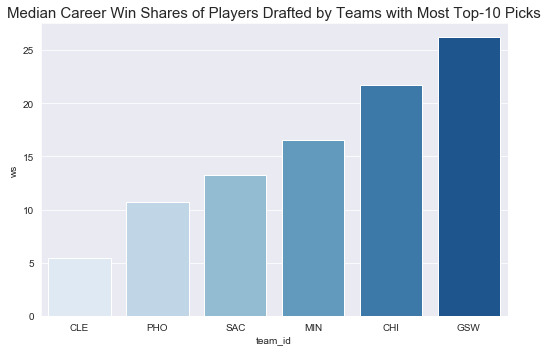

In [104]:
#Question 2 - Win shares for teams with most picks

plt.figure(figsize=(8,5))
top_pick_teams = most_top10_picks.index.tolist()
top_team_ws = df.groupby('team_id').median().ws[top_pick_teams].sort_values(ascending=True)
sns.barplot(x=top_team_ws.index,y=top_team_ws.values,palette='Blues')

plt.title('Median Career Win Shares of Players Drafted by Teams with Most Top-10 Picks',fontdict={'fontsize':15})
plt.ylabel('ws')

plt.tight_layout()

plt.savefig('barplot.png')

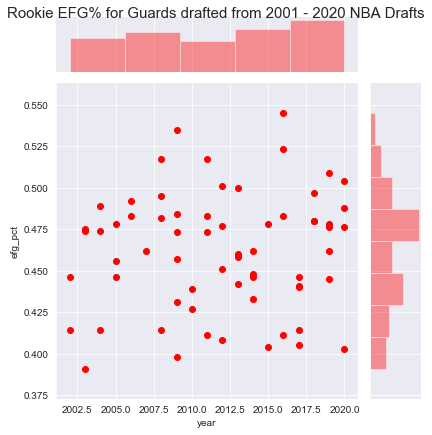

In [105]:
#Question 3 - EFG% among guards over time

guards = df[df.pos == 'Guard'].reset_index()
guards

plot = sns.jointplot(x='year',y='efg_pct',data=guards,kind='scatter',color='red')
plot.fig.suptitle('Rookie EFG% for Guards drafted from 2001 - 2020 NBA Drafts', x=0.5, y=1, fontsize=15)
plt.tight_layout()


plt.savefig('jointplot.png')

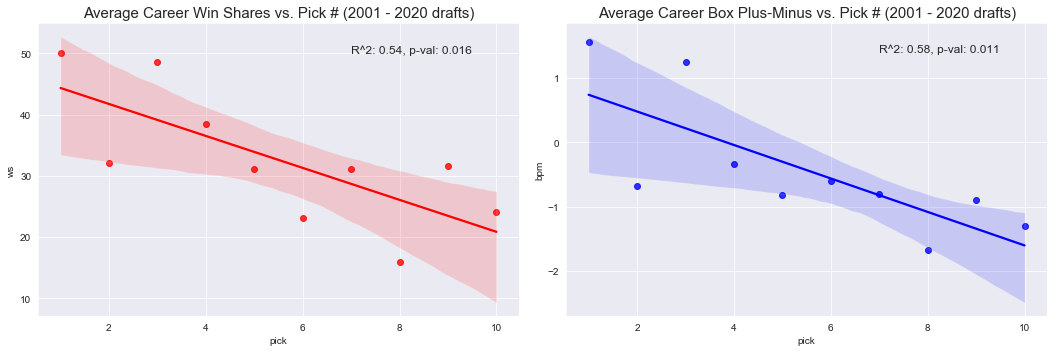

In [106]:
#Question 4 - Win Shares, Box Plus-Minus vs Pick #

by_pick = df.reset_index().groupby('pick').mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style('darkgrid')

ws_stats = stats.pearsonr(by_pick.pick,by_pick.ws)
sns.regplot(ax = axs[0], x='pick',y='ws',data=by_pick,color='red')
axs[0].set_title('Average Career Win Shares vs. Pick # (2001 - 2020 drafts)',fontsize=15)
axs[0].text(7,50,'R^2: ' + str((ws_stats[0]**2).round(2)) + ', p-val: ' + str(ws_stats[1].round(3)), fontsize=12)

bpm_stats = stats.pearsonr(by_pick.pick,by_pick.bpm)
sns.regplot(ax = axs[1], x='pick',y='bpm',data=by_pick, color = 'blue')
axs[1].set_title('Average Career Box Plus-Minus vs. Pick # (2001 - 2020 drafts)',fontsize=15)
axs[1].text(7,1.4,'R^2: ' + str((bpm_stats[0]**2).round(2)) + ', p-val: ' + str(bpm_stats[1].round(3)), fontsize=12)

plt.tight_layout()

plt.savefig('scatterplots.png')

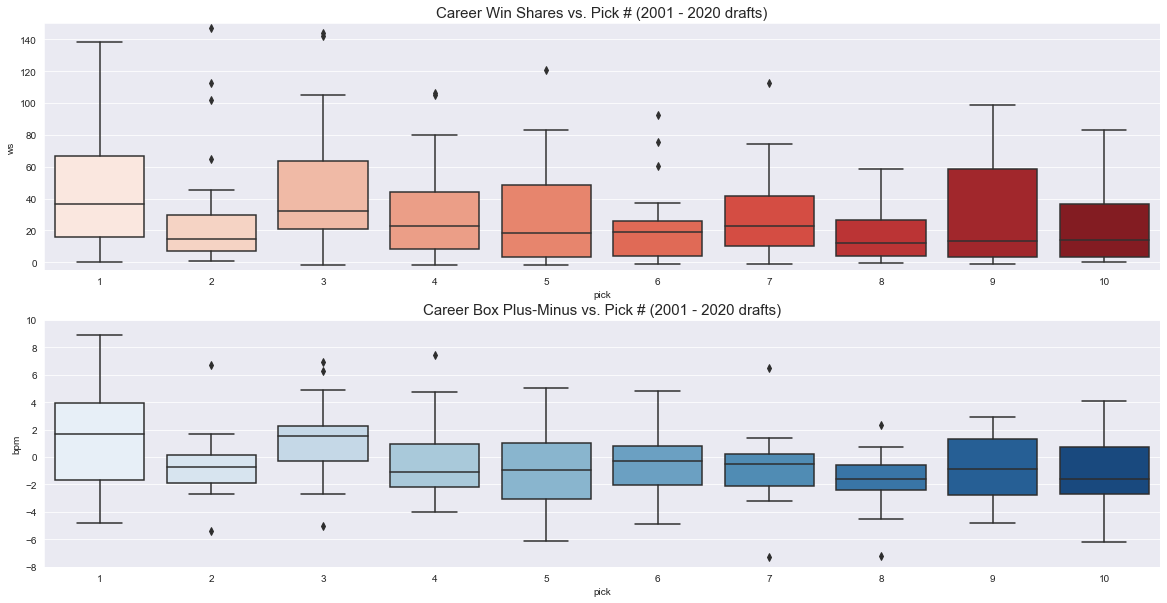

In [107]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(ax = axs[0], x='pick',y='ws',data=df.reset_index(),palette='Reds')
axs[0].set_ylim(-5,150)
axs[0].set_title('Career Win Shares vs. Pick # (2001 - 2020 drafts)',fontsize=15)

sns.boxplot(ax = axs[1], x='pick',y='bpm',data=df.reset_index(),palette='Blues')
axs[1].set_ylim(-8,10)
axs[1].set_title('Career Box Plus-Minus vs. Pick # (2001 - 2020 drafts)',fontsize=15)

plt.savefig('boxplots.png')

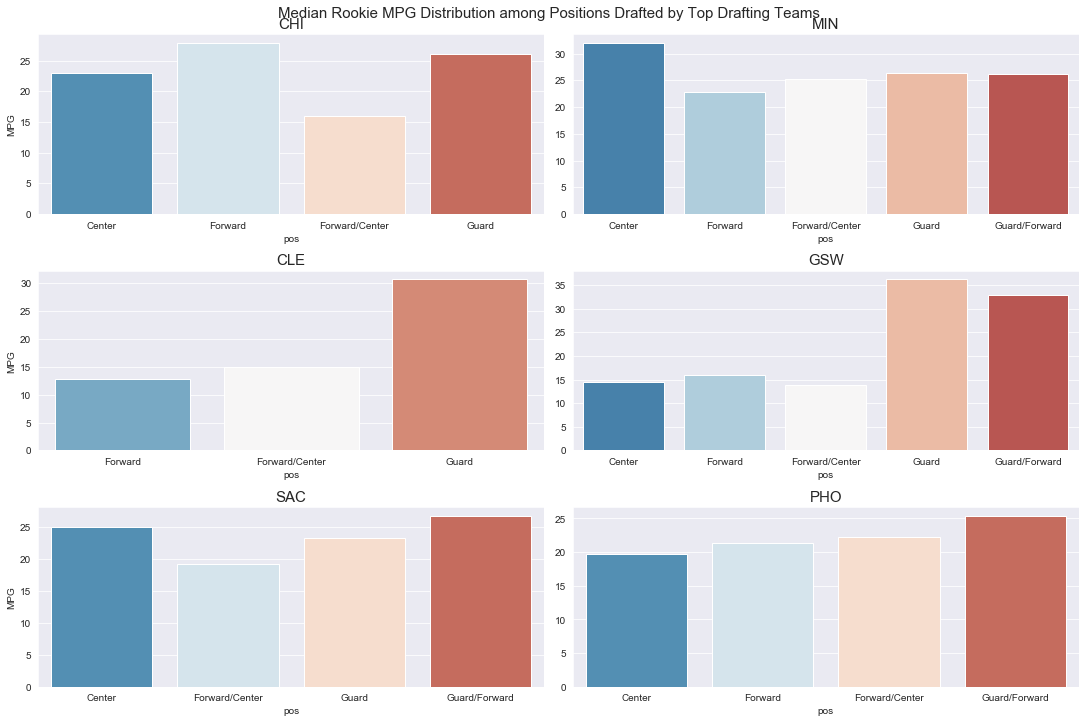

In [113]:
#Question 5 - MPG Distribution among Positions drafted by select teams

most_picks_teams = np.array(most_top10_picks.index)

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Median Rookie MPG Distribution among Positions Drafted by Top Drafting Teams', x=0.5, y=1, fontsize=15)

ax_list = [axs[0,0],axs[0,1],axs[1,0],axs[1,1],axs[2,0],axs[2,1]]

for i in range(6):
    
    data = df[df.team_id == most_picks_teams[i]].groupby('pos').median().mp_per_g
    sns.barplot(ax = ax_list[i], x = data.index, y = data.values, palette='RdBu_r')
    ax_list[i].set_title(most_picks_teams[i],fontsize=15)
   
plt.tight_layout()
plt.setp(axs[:,0],ylabel = 'MPG')

plt.savefig('barplot_grid.png')